# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [1]:
from cesnet_datazoo.datasets import CESNET_QUIC22, CESNET_TLS22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

Prepare the dataset with config and check its columns.

In [2]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
    # return_other_fields=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()
data_df.columns

Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Add imports.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Prepare the dataset dataframe.
Convert APP column to APP_NAME.

In [4]:
data_df["APP_NAME"] = data_df["APP"].apply(lambda x: dataset._tables_app_enum.get(x, "Unknown"))

data_df["APP_NAME"].value_counts()

APP_NAME
bongacams                6830
cloudflare-cdnjs         6355
alza-identity            6323
flightradar24            6110
playradio                5551
                         ... 
google-authentication       9
instagram                   9
ebay-kleinanzeigen          9
google-autofill             8
uber                        7
Name: count, Length: 101, dtype: int64

## Feature extraction

Create new features.

In [5]:
data_df["BYTES_PER_PACKET"] = data_df["BYTES"] / data_df["PACKETS"]
data_df["BYTES_PER_PACKET_REV"] = data_df["BYTES_REV"] / data_df["PACKETS_REV"]

Get only the columns that are needed for clustering.

In [6]:
features_to_extract = ["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION",
                       "PPI_LEN", "PPI_ROUNDTRIPS", "PPI_DURATION",
                       "BYTES_PER_PACKET", "BYTES_PER_PACKET_REV"]

features_array = data_df[features_to_extract].to_numpy()
app_array = data_df[["APP"]].to_numpy().reshape(-1)

## Preprocessing

Standardize the features.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## Application choice

In [8]:
import numpy as np
from itertools import combinations

def find_most_separable_class_pairs(X, y, top_n=5):
    unique_classes = np.unique(y)
    class_pairs = list(combinations(unique_classes, 2))
    distances = []

    for class1, class2 in class_pairs:
        mask = (y == class1) | (y == class2)
        subset_X = X[mask]
        subset_y = y[mask]

        mean1 = subset_X[subset_y == class1].mean(axis=0)
        mean2 = subset_X[subset_y == class2].mean(axis=0)

        dist = np.linalg.norm(mean1 - mean2)  # Euclidean distance
        distances.append((class1, class2, dist))

    # Sort by descending distance
    distances.sort(key=lambda x: x[2], reverse=True)

    # Print top N
    print(f"Top {top_n} most separable class pairs by centroid distance:")
    for i in range(min(top_n, len(distances))):
        c1, c2, dist = distances[i]
        print(f"{c1} vs {c2} → distance = {dist:.2f}")

    return distances[:top_n]

In [9]:
import numpy as np
from itertools import combinations

def select_most_different_classes(X, y, num_classes=5):
    unique_classes = np.unique(y)
    centroids = {}
    for cls in unique_classes:
        centroids[cls] = X[y == cls].mean(axis=0)

    classes = list(centroids.keys())
    n = len(classes)

    # Build distance matrix
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(centroids[classes[i]] - centroids[classes[j]])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # symmetric

    # Step 1: pick the pair with the maximum distance
    i, j = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    selected_indices = [i, j]
    remaining_indices = set(range(n)) - set(selected_indices)

    # Step 2: iteratively add the class farthest from current set
    while len(selected_indices) < num_classes and remaining_indices:
        best_candidate = None
        best_min_dist = -1
        for idx in remaining_indices:
            min_dist = min(distance_matrix[idx, sel] for sel in selected_indices)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_candidate = idx
        selected_indices.append(best_candidate)
        remaining_indices.remove(best_candidate)

    selected_classes = [classes[idx] for idx in selected_indices]

    print(f"Selected classes (most different from each other): {selected_classes}")
    return selected_classes


In [10]:
import numpy as np
from itertools import combinations
from numpy.linalg import inv, det

def bhattacharyya_distance(mean1, cov1, mean2, cov2):
    cov_avg = (cov1 + cov2) / 2
    mean_diff = mean1 - mean2
    term1 = 0.125 * np.dot(np.dot(mean_diff.T, inv(cov_avg)), mean_diff)
    term2 = 0.5 * np.log(det(cov_avg) / np.sqrt(det(cov1) * det(cov2)))
    return term1 + term2

def find_most_different_classes_statistical(X, y, num_classes=5):
    unique_classes = np.unique(y)
    class_stats = {}
    for cls in unique_classes:
        X_cls = X[y == cls]
        mean = X_cls.mean(axis=0)
        cov = np.cov(X_cls, rowvar=False) + 1e-6 * np.eye(X_cls.shape[1])  # small regularization
        class_stats[cls] = (mean, cov)

    classes = list(class_stats.keys())
    n = len(classes)

    # Build distance matrix
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            mean1, cov1 = class_stats[classes[i]]
            mean2, cov2 = class_stats[classes[j]]
            dist = bhattacharyya_distance(mean1, cov1, mean2, cov2)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    # Step 1: pick the pair with maximum distance
    i, j = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    selected_indices = [i, j]
    remaining_indices = set(range(n)) - set(selected_indices)

    # Step 2: iteratively add the class farthest from current set
    while len(selected_indices) < num_classes and remaining_indices:
        best_candidate = None
        best_min_dist = -1
        for idx in remaining_indices:
            min_dist = min(distance_matrix[idx, sel] for sel in selected_indices)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_candidate = idx
        selected_indices.append(best_candidate)
        remaining_indices.remove(best_candidate)

    selected_classes = [classes[idx] for idx in selected_indices]

    print(f"Selected classes (most statistically different): {selected_classes}")
    return selected_classes


In [11]:
import numpy as np
from itertools import combinations
from numpy.linalg import inv

def lda_separation_score(X1, X2):
    # Means
    mean1 = X1.mean(axis=0)
    mean2 = X2.mean(axis=0)

    # Covariances
    cov1 = np.cov(X1, rowvar=False) + 1e-6 * np.eye(X1.shape[1])
    cov2 = np.cov(X2, rowvar=False) + 1e-6 * np.eye(X2.shape[1])

    # Within-class scatter
    S_W = cov1 + cov2

    # Between-class scatter
    mean_diff = (mean1 - mean2).reshape(-1, 1)
    S_B = np.dot(mean_diff, mean_diff.T)

    # LDA score: trace(S_W^-1 S_B)
    score = np.trace(np.dot(inv(S_W), S_B))
    return score

def find_most_different_classes_lda(X, y, num_classes=5):
    unique_classes = np.unique(y)
    class_data = {cls: X[y == cls] for cls in unique_classes}

    classes = list(class_data.keys())
    n = len(classes)

    # Build separation score matrix
    score_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            score = lda_separation_score(class_data[classes[i]], class_data[classes[j]])
            score_matrix[i, j] = score
            score_matrix[j, i] = score

    # Step 1: pick the pair with maximum LDA separation score
    i, j = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
    selected_indices = [i, j]
    remaining_indices = set(range(n)) - set(selected_indices)

    # Step 2: iteratively add the class that maximizes minimum separation to current set
    while len(selected_indices) < num_classes and remaining_indices:
        best_candidate = None
        best_min_score = -np.inf
        for idx in remaining_indices:
            min_score = min(score_matrix[idx, sel] for sel in selected_indices)
            if min_score > best_min_score:
                best_min_score = min_score
                best_candidate = idx
        selected_indices.append(best_candidate)
        remaining_indices.remove(best_candidate)

    selected_classes = [classes[idx] for idx in selected_indices]

    print(f"Selected classes (most LDA separable): {selected_classes}")
    return selected_classes


In [12]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif

def mutual_info_separation_score(X1, X2):
    # Stack data and create labels
    X_pair = np.vstack((X1, X2))
    y_pair = np.array([0] * len(X1) + [1] * len(X2))

    # Compute mutual information between each feature and labels
    mi = mutual_info_classif(X_pair, y_pair, discrete_features=False, random_state=42)

    # Aggregate mutual information score (average over features)
    score = np.mean(mi)
    return score

def find_most_different_classes_mi(X, y, num_classes=5):
    unique_classes = np.unique(y)
    class_data = {cls: X[y == cls] for cls in unique_classes}

    classes = list(class_data.keys())
    n = len(classes)

    # Build MI-based separation score matrix
    score_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            score = mutual_info_separation_score(class_data[classes[i]], class_data[classes[j]])
            score_matrix[i, j] = score
            score_matrix[j, i] = score

    # Step 1: pick the pair with maximum MI score
    i, j = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
    selected_indices = [i, j]
    remaining_indices = set(range(n)) - set(selected_indices)

    # Step 2: iteratively add the class with best minimum MI to current set
    while len(selected_indices) < num_classes and remaining_indices:
        best_candidate = None
        best_min_score = -np.inf
        for idx in remaining_indices:
            min_score = min(score_matrix[idx, sel] for sel in selected_indices)
            if min_score > best_min_score:
                best_min_score = min_score
                best_candidate = idx
        selected_indices.append(best_candidate)
        remaining_indices.remove(best_candidate)

    selected_classes = [classes[idx] for idx in selected_indices]

    print(f"Selected classes (most separable via MI): {selected_classes}")
    return selected_classes

In [1]:
# top_apps = select_most_different_classes(preprocessed_array, app_array)

# top_apps_distances = find_most_separable_class_pairs(preprocessed_array, app_array, 5)
#
# all_top_apps = []
#
# for app in top_apps_distances:
#     all_top_apps.append(app[0])
#     all_top_apps.append(app[1])
#
# top_apps = list(set(all_top_apps))

# [40, 81, 34, 15, 23, 54, 2, 63, 80, 95]
#top 1

top_apps = find_most_different_classes_statistical(preprocessed_array, app_array, num_classes=5)

#top 2
# [40, 81, 34]
# top_apps = find_most_different_classes_lda(preprocessed_array, app_array, 5)

# top_apps = find_most_different_classes_mi(preprocessed_array, app_array, 10)

top_apps

NameError: name 'find_most_different_classes_statistical' is not defined

In [14]:
only_top_apps_array = np.isin(app_array, top_apps)

filtered_app_array = app_array[only_top_apps_array]
filtered_preprocessed_array = preprocessed_array[only_top_apps_array]

In [40]:
dataset._tables_app_enum.get(83)

'kiwi-com'

In [17]:
np.unique(filtered_app_array, return_counts=True)

(array([15, 23, 34, 40, 81]), array([200,   8,   9,  39,  45]))

In [18]:
data_df[data_df["APP"] == 34]

,PPI,BYTES,BYTES_REV,PACKETS,PACKETS_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION,FLOW_ENDREASON_IDLE,...,IPT_BIN3_REV,IPT_BIN4_REV,IPT_BIN5_REV,IPT_BIN6_REV,IPT_BIN7_REV,IPT_BIN8_REV,APP,APP_NAME,BYTES_PER_PACKET,BYTES_PER_PACKET_REV
4894,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1228.0,2456.0,1.0,2.0,0.001391,3.0,1.0,0.001,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34,instagram,1228.000000,1228.000000
6963,"[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1228.0,2456.0,1.0,2.0,0.001585,3.0,1.0,0.002,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34,instagram,1228.000000,1228.000000
21324,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1228.0,1228.0,1.0,1.0,0.000711,2.0,1.0,0.001,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34,instagram,1228.000000,1228.000000
25116,"[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1228.0,2456.0,1.0,2.0,0.002221,3.0,1.0,0.002,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34,instagram,1228.000000,1228.000000
31642,"[[0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1228.0,1228.0,1.0,1.0,0.012759,2.0,1.0,0.013,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34,instagram,1228.000000,1228.000000
42789,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1228.0,1228.0,1.0,1.0,0.000836,2.0,1.0,0.000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34,instagram,1228.000000,1228.000000
59908,"[[0.0, 8.0, 0.0, 0.0, 20.0, 4.0, 1.0, 1.0, 0.0...",2892.0,10325.0,8.0,15.0,6.753503,23.0,5.0,6.754,1.0,...,3.0,0.0,1.0,2.0,1.0,2.0,34,instagram,361.500000,688.333313
70068,"[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1228.0,2456.0,1.0,2.0,0.002268,3.0,1.0,0.002,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34,instagram,1228.000000,1228.000000
95520,"[[0.0, 7.0, 0.0, 0.0, 43.0, 0.0, 6.0, 0.0, 6.0...",6956.0,6409.0,17.0,13.0,0.257932,30.0,5.0,0.258,1.0,...,2.0,1.0,0.0,0.0,0.0,0.0,34,instagram,409.176483,493.000000


## KMeans

### Clustering

Cluster the data using KMeans.

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=np.unique(filtered_app_array).shape[0], random_state=42)
kmeans.fit(filtered_preprocessed_array)

KMeans(n_clusters=5, random_state=42)

Count of clusters.

In [20]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([  3, 205,  39,  47,   7]))

In [21]:
from sklearn.cluster import KMeans

NUMBER_OF_MULTIPLIERS = 3

number_of_clusters = np.unique(filtered_app_array).shape[0]

kmeans_partitions = []

for cluster_multiplier in range(1, NUMBER_OF_MULTIPLIERS+1):
    kmeans = KMeans(n_clusters=number_of_clusters * cluster_multiplier, random_state=42)
    kmeans.fit(filtered_preprocessed_array)
    kmeans_partitions.append(kmeans.labels_)

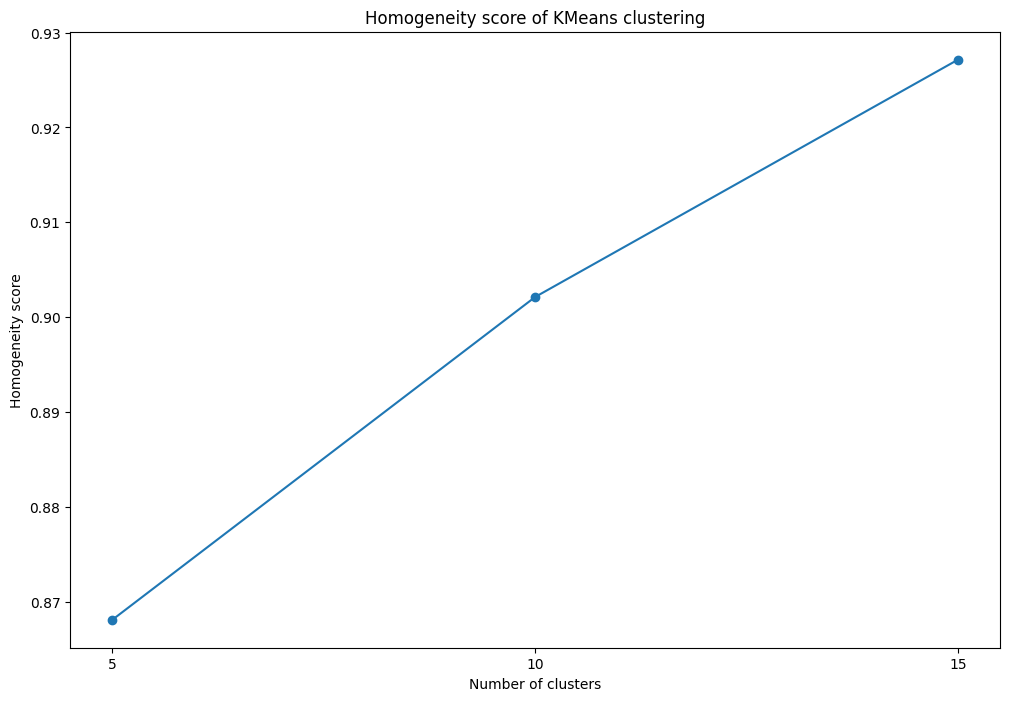

In [22]:
from sklearn.metrics.cluster import homogeneity_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), [homogeneity_score(filtered_app_array, kmeans) for kmeans in kmeans_partitions], marker='o')
ax.set_title("Homogeneity score of KMeans clustering")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Homogeneity score")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))
plt.show()
fig.savefig("kmeans_homogeneity.png", bbox_inches='tight')

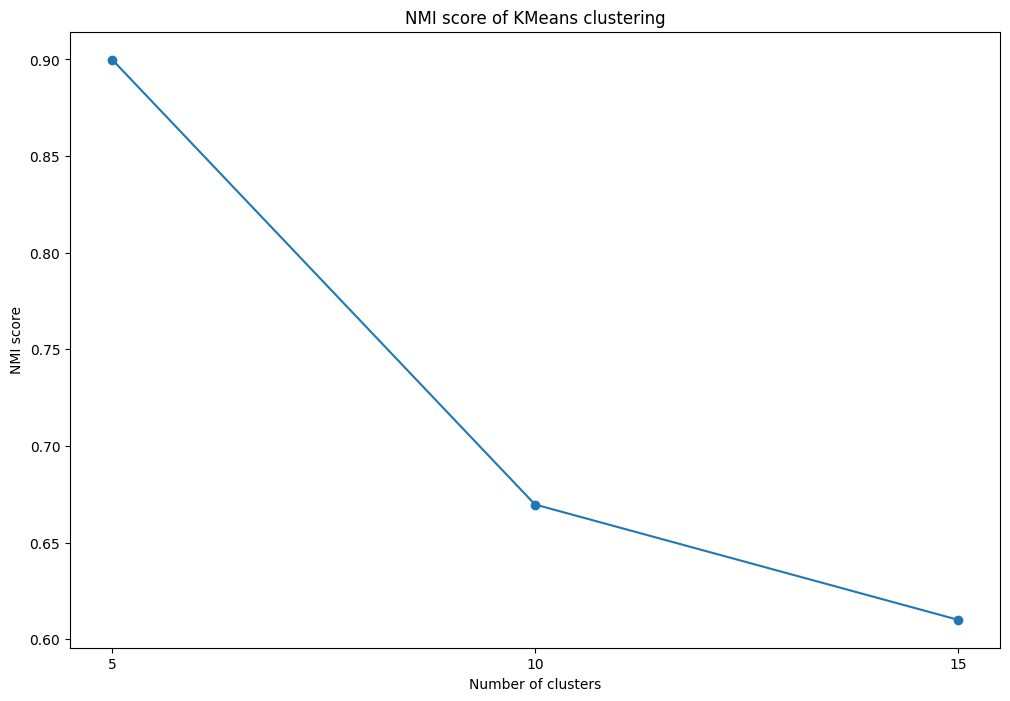

In [23]:
from sklearn.metrics.cluster import normalized_mutual_info_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), [normalized_mutual_info_score(filtered_app_array, kmeans) for kmeans in kmeans_partitions], marker='o')
ax.set_title("NMI score of KMeans clustering")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("NMI score")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))
plt.show()
fig.savefig("kmeans_nmi.png", bbox_inches='tight')

### Evaluation

In [24]:
from sklearn.metrics.cluster import homogeneity_score

homogeneity_score(filtered_app_array, kmeans.labels_)

0.9271421367205621

In [25]:
from sklearn.metrics.cluster import normalized_mutual_info_score

normalized_mutual_info_score(filtered_app_array, kmeans.labels_)

0.6101019527785349

## DBSCAN

### Preparation

Let's start with elbow method to find the optimal number of clusters.

In [26]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

# If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).
neighbors = NearestNeighbors(n_neighbors=16).fit(filtered_preprocessed_array)
distances, _ = neighbors.kneighbors(filtered_preprocessed_array)

(60.0, 100.0, 0.0, 1.5)

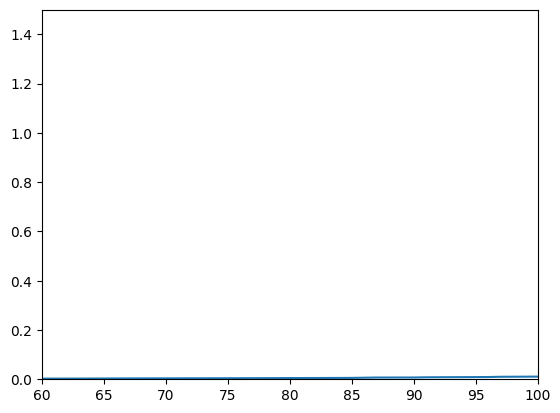

In [27]:
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.axis([60, 100, 0, 1.5])

### Clustering

DBSCAN clustering.

In [28]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=7).fit(filtered_preprocessed_array)

In [29]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([ 16, 201,  38,  39,   7]))

### Evaluation

In [30]:
homogeneity_score(filtered_app_array, dbscan.labels_)

0.8685972554232859

In [31]:
normalized_mutual_info_score(filtered_app_array, dbscan.labels_)

0.8613187481906424

# HDBSCAN

In [32]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_samples=7).fit(filtered_preprocessed_array)

In [33]:
np.unique(hdbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([65,  7, 39, 43, 15, 12, 38, 10,  9,  7, 19, 23, 14]))

In [34]:
homogeneity_score(filtered_app_array, hdbscan.labels_)

0.8460415716472369

In [35]:
normalized_mutual_info_score(filtered_app_array, hdbscan.labels_)

0.517481328295092

## Visualization

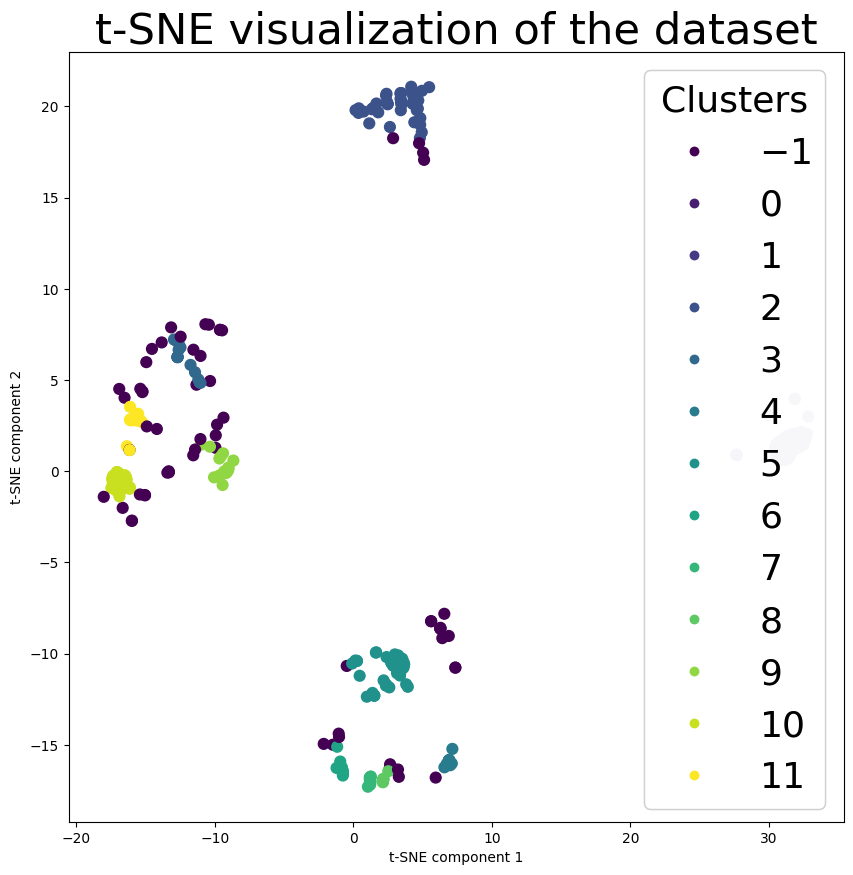

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_array = tsne.fit_transform(filtered_preprocessed_array)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 26})
# scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=filtered_app_array, cmap='viridis', s=60)
scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=hdbscan.labels_, cmap='viridis', s=60)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.set_title("t-SNE visualization of the dataset")
ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")
ax.add_artist(legend)
plt.show()
fig.savefig("hdbscan.png", bbox_inches='tight')